### Imports

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import numpy as np
import glob2
import h5py

%matplotlib inline

In [2]:
import ipynb
import importlib

In [3]:
import ipynb.fs.full.modules.Environment as Environment
import ipynb.fs.full.modules.Bees as Bees
import ipynb.fs.full.modules.Utils as Utils
import ipynb.fs.full.modules.Config as config
import ipynb.fs.full.modules.BeeKeeper as BeeKeeper

# RUN

In [4]:
importlib.reload(Environment)
importlib.reload(Bees)
importlib.reload(Utils)
importlib.reload(config)
importlib.reload(BeeKeeper)

<module 'ipynb.fs.full.modules.BeeKeeper' (C:\Users\mliuzzolino\Desktop\bee_communication_v2\ipynb\modules\BeeKeeper.ipynb)>

In [5]:
config.RANDOM_SEED, config.WORKER_BIAS_SCALAR

(80, 5.0)

In [6]:
def create_bees():
    bees = []
    for bee_i in range(config.NUM_WORKERS):
        bee_params = config.BEE_PARAMS
        bee_params["num"] = bee_i
        bee = Bees.Worker(bee_params)
        bees.append(bee)
    return bees

In [11]:
np.random.seed(config.RANDOM_SEED)

# Setup directory
Utils.setup_directories(config.SAVE_FOLDER)

# CREATE CLASS OBJECTS
# ------------------------------------------------------------
environment = Environment.Environment(config.ENVIRONMENT_PARAMS)
queen_bee = Bees.Queen(config.QUEEN_PARAMS)
bees = create_bees()
bee_keeper = BeeKeeper.BeeKeeper(config.BEE_KEEPER_PARAMS)
# ------------------------------------------------------------

# Cleanup previous pngs
for old_file_path in glob2.glob(f"{config.SAVE_FOLDER}/t*.png"):
    os.remove(old_file_path)

# ============================================================
try:
    for global_i, t_i in enumerate(environment):
        sys.stdout.write(f"\rTimestep: {global_i+1}/{environment.t_grid.shape[0]}")
        sys.stdout.flush()

        # Step 1: Check for and build sources list for current timestep
        # ----------------------------------------------------
        # Update pheromone list from queen bee
        environment.update_pheromone_sources(queen_bee, t_i)

        # Update pheromone list from worker bees
        for bee_i, bee in enumerate(bees):
            environment.update_pheromone_sources(bee, t_i)
        # ----------------------------------------------------

        # Step 2: Build Concentration map and get gradients
        # ----------------------------------------------------
        # Init concentration map for current timestep to 0's
        # environment.init_concentration_map()
        # Iterate through pheromone sources and build concentration maps
        # -- for each pheromone source, calculate gradient for each bee
        for pheromone_src in environment.pheromone_sources:
            # Update concentration map with x, y, A, dt, etc.
            pheromone_src_C = environment.update_concentration_map(t_i, pheromone_src)   
            
            # Iterate through list of active bees and calculate gradient
            for bee in bees:
                environment
                threshold_met = bee.check_threshold(environment, pheromone_src_C)
                if threshold_met:
                    grad = environment.calculate_gradient(t_i, bee.x, bee.y, pheromone_src)
                    bee.update_gradient(grad)
        # ----------------------------------------------------

        # Step 3: Update bees & environment
        # ----------------------------------------------------
        queen_bee.update()

        for bee_i, bee in enumerate(bees):
            # Check if bee's threshold is met then update based on state
            _ = bee.check_threshold(environment, environment.concentration_map)
            bee.update()
            
            # Measure and store bee info
            bee_keeper.measure_bees(bee, queen_bee, global_i)

        # Store concentration maps
        bee_keeper.measure_environment(environment)
        # ----------------------------------------------------

        # Take steps (update movement, clear grads, etc)
        queen_bee.step()
        for bee in bees:
            bee.step(environment)
    
    bee_keeper.log_data_to_handy_dandy_notebook()
    
except KeyboardInterrupt:
    print("\nEnding early.")
    bee_keeper.log_data_to_handy_dandy_notebook()
    

Creating concentration map...
Creating timecourse...
Timestep: 32/200
Ending early.


In [21]:
xxx = np.array(bee_keeper.environment_history)

In [22]:
xxx.shape

(31, 601, 601)

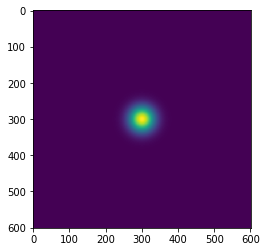

In [23]:
import matplotlib.pyplot as plt
plt.imshow(xxx[0])


In [ ]:
fig, ax = plt.subplots(1, figsize=(12,12))
ax.imshow(np.concatenate())